# **Problem 1 [Logistic regression] - 15 points**

Use an existing package of your choice to train and test a logistic regression model on the UCI Adult dataset.

(a) Split the original data into 75% for training and the remaining 25% for testing, selected at random.
Train a logistic regression model on the training set and output the following metrics on the testing
set:
1. Accuracy, Error;
2. Precision, Recall, F1 score;
3. Plot a ROC curve of the classifier and report the AUC metric.

(b) Use L1 and L2 regularization with 3 different λ parameters (0.1, 0.01, and 0.001). Write down some
observations comparing the two regularization methods in terms of the coefficients of the models and
accuracy metrics.


In [2]:
# imports libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [3]:
# define column names 

columns = [
           'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
           'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Income'
           ]

In [4]:
# import data from UCI repo 

trainset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names= columns)
testset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', names= columns)

print(trainset.shape)
print(testset.shape)

(32561, 15)
(16282, 15)


In [5]:
trainset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
trainset.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
# # there is a slight difference in the data of trainset and the testset

# for column in categorical_columns:
#   print(f'For the column: {column}, There are {trainset[column].value_counts().count()} unique values')

In [ ]:
# # testset
# for column in categorical_columns:
#   print(f'For the column: {column}, There are {testset[column].value_counts().count()} unique values')

We see that the native country has lesser unique values that means the test data does not have all the different countries. this will be resolved through binning.

## Bin categorical features

There are more categorical columns than numeric columns. Since the categorical values have more variety binning them into a smaller bins is beneficial not only for analysis standpoint but also computationally since the categorical variables anyway has to one hot encoded.

In [8]:
def preprocess(data):
  # replace workclass having ? with nan
  data = data.replace({"workclass": ' ?'}, np.nan)

  # workclass
  unemployed_list = [" Without-pay", " Never-worked"]
  gov_list = [" Local-gov", " State-gov", " Federal-gov"]

  data.loc[(data.workclass.isin(unemployed_list)), 'workclass'] = " Unemployed"
  data.loc[(data.workclass.isin(gov_list)), 'workclass'] = " Gov"

  # education
  hs_grad_list = [' HS-grad',' 11th',' 10th',' 9th',' 12th']
  elementary_list = [' 1st-4th',' 5th-6th',' 7th-8th']

  data.loc[(data.education.isin(hs_grad_list)), 'education'] = " HS-grad"
  data.loc[(data.education.isin(elementary_list)), 'education'] = " elementary_school"  

  # martial status 
  married_list = [" Married-AF-spouse", " Married-civ-spouse", " Married-spouse-absent"]
  not_married_list = [" Never-married", " Divorced", " Separated"]

  data.loc[(data['marital-status'].isin(married_list)), 'marital-status'] = " Married"
  data.loc[(data['marital-status'].isin(not_married_list)), 'marital-status']  = " Not-Married"

  # native country 
  data = data.replace({'native-country': ' ?'}, np.nan)

  north_america_list = [" Canada", " Cuba", " Dominican-Republic", " El-Salvador", " Guatemala", " Haiti", " Honduras", 
                        " Jamaica", " Mexico", " Nicaragua", " Outlying-US(Guam-USVI-etc)", " Puerto-Rico", " Trinadad&Tobago", " United-States"]
  asia_list = [" Cambodia", " China", " Hong", " India", " Iran", " Japan", " Laos", " Philippines", " Taiwan", " Thailand", " Vietnam"]
  south_america_list = [" Columbia", " Ecuador", " Peru"]
  europe_list = [" England", " France", " Germany", " Greece", " Holand-Netherlands", " Hungary", " Ireland", " Italy", " Poland", " Portugal", " Scotland", " Yugoslavia"]
  other = [' South']

  data.loc[(data['native-country'].isin(north_america_list)), 'native-country'] = ' North-America'
  data.loc[(data['native-country'].isin(asia_list)), 'native-country'] = ' Asia'
  data.loc[(data['native-country'].isin(south_america_list)), 'native-country'] = ' South-America'
  data.loc[(data['native-country'].isin(europe_list)), 'native-country'] = ' Europe'
  data.loc[(data['native-country'].isin(other)), 'native-country'] = ' Other'

  # change the income to 0/1
  data = data.replace({'Income': ' <=50K'}, 0)
  data = data.replace({'Income': ' >50K'}, 1)
  data = data.replace({'Income': ' <=50K.'}, 0)
  data = data.replace({'Income': ' >50K.'}, 1)


  # occupation
  data = data.replace({'occupation': ' ?'}, np.nan)

  return data 

In [9]:
# trainset and testset 

trainset = preprocess(trainset)
testset = preprocess(testset)

In [10]:
# categorical and the numeric columns 
# capital gain and capital loss values are mostly absent for majority values

categorical_columns = list(trainset.select_dtypes(include=['object']).columns)
exclude_columns = ['capital-gain', 'capital-loss', 'Income']
numeric_columns = list(trainset.select_dtypes(include=['int64']).columns)

print('Number of categorical columns', len(categorical_columns))
print('Number of excluded columns', len(exclude_columns))
print('Number of numeric columns', len(numeric_columns))

Number of categorical columns 8
Number of excluded columns 3
Number of numeric columns 7


In [11]:
# 
trainset = trainset.dropna()
testset = testset.dropna()

X_train = trainset.drop(['Income'] + exclude_columns, axis=1)
y_train = trainset['Income']
X_test = testset.drop(['Income'] + exclude_columns, axis=1)
y_test = testset['Income']

In [12]:
# scale data 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def scale_data(data):
  # scale the numerical values 
  for column in list(set(numeric_columns) - set(exclude_columns)):
    data[column + '_s'] = scaler.fit_transform(data[column].values.reshape(-1,1))
  return data 

In [13]:
X_train = scale_data(X_train)
X_test = scale_data(X_test)

# convert the categorical columns to one hot encoding 
temp1 = pd.get_dummies(X_train[categorical_columns])
# after convertion drop the original columns 
X_train_processed = X_train.drop(categorical_columns, axis=1)
# also drop the numeric columns because we have the scaled columns
X_train_processed = X_train_processed.drop(list(set(numeric_columns) - set(exclude_columns)), axis=1)
# finally we have scaled numeric columns and one hot coded categorical columns 
X_train_processed = pd.concat([X_train_processed, temp1], axis=1)

temp2 = pd.get_dummies(X_test[categorical_columns])
X_test_processed = X_test.drop(categorical_columns, axis=1)
X_test_processed = X_test_processed.drop(list(set(numeric_columns) - set(exclude_columns)), axis=1)
X_test_processed = pd.concat([X_test_processed, temp2], axis=1)

In [14]:
X_train_processed.head()

,age_s,fnlwgt_s,hours-per-week_s,education-num_s,workclass_ Gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ Unemployed,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education_ elementary_school,marital-status_ Married,marital-status_ Not-Married,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Asia,native-country_ Europe,native-country_ North-America,native-country_ Other,native-country_ South-America
0,0.301370,0.043338,0.397959,0.800000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
1,0.452055,0.047277,0.122449,0.800000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2,0.287671,0.137244,0.397959,0.533333,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3,0.493151,0.150212,0.397959,0.400000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
4,0.150685,0.220703,0.397959,0.800000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0


## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression


# C value determines the regularization and if the value of C is very high the lambda will be close to 0 making the loss function close to standard without regularization
# default max iteration is 100 and the algorithm does not converge within limit 

# fit the model on train set 
model = LogisticRegression(C=1e42, max_iter=1000)
model.fit(X_train_processed, y_train)

# test the model on test set 
y_pred = model.predict(X_test_processed)
accuracy_score(y_pred, y_test)

0.8302788844621514

In [14]:
# log likelihood 
from sklearn.metrics import log_loss
log_loss(y_test, y_pred)

5.862009992281244

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89     11360
         1.0       0.69      0.57      0.62      3700

    accuracy                           0.83     15060
   macro avg       0.78      0.74      0.76     15060
weighted avg       0.82      0.83      0.82     15060



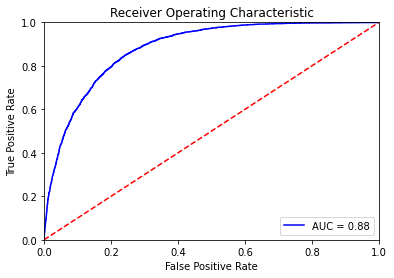

In [27]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = model.predict_proba(X_test_processed)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Testing various regularization parameters

In [28]:
# L1 penalty
C = [.1, .01, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train_processed, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_processed, y_train))
    print('Test accuracy:', clf.score(X_test_processed, y_test))
    print('')

C: 0.1
Coefficient of each feature: [[ 2.63768498  0.34301998  2.01379179  3.86529239 -0.01925367  0.
   0.22764566 -0.40489026  0.         -0.26800028 -0.03657819  0.
   0.04091308 -0.12077208  0.08271258  0.          0.44560539 -0.00779559
   0.          0.         -0.97681853 -0.47793205  0.          0.
   0.          0.77694832 -0.88940293 -0.65883768 -0.31329719 -0.92469077
   0.          0.46099355  0.27704242  0.24511009  0.490495   -0.11863697
   0.81917018  0.         -0.19805841 -1.08240455 -0.05143497  2.04841667
   0.          0.          0.         -0.00954276  0.12529613 -0.83557379
   0.          0.          0.          0.          0.         -0.10590709]]
Training accuracy: 0.8299847490219482
Test accuracy: 0.8308100929614873

C: 0.01
Coefficient of each feature: [[ 0.12655866  0.          0.37795227  1.36388542  0.         -0.06552743
   0.0715443  -0.08687328  0.          0.          0.          0.
   0.         -0.73329656  0.08083476  0.          0.         -0.32213

In [31]:
# L2 penalty
C = [.1, .01, .001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    clf.fit(X_train_processed, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_processed, y_train))
    print('Test accuracy:', clf.score(X_test_processed, y_test))
    print('')

C: 0.1
Coefficient of each feature: [[ 2.2453329   0.51149765  1.80840194  1.60771498 -0.37372248 -0.32925038
  -0.01906782 -0.72145144 -0.25596595 -0.43335439 -0.34351959  0.03596874
   0.62515503 -0.72620601  0.30561489 -0.30254188  0.82082841 -0.43175135
  -1.24965192  0.01602806 -1.09260841 -0.62287772 -0.0539683  -0.03497716
  -0.05473197  0.74168881 -0.91938138 -0.77943173 -0.4196648  -0.99522344
  -0.42895319  0.41654503  0.32426443  0.22121816  0.48665768 -0.2035002
   0.24580284 -0.46993751 -0.78443998 -1.53149977 -0.55209029  1.39270664
  -0.4722138  -0.19159622 -0.29375615 -0.56679438 -0.17509752 -1.24657421
  -0.45288386 -0.30843536 -0.03698996 -0.16205136 -0.55354549 -0.63843589]]
Training accuracy: 0.8298189775213846
Test accuracy: 0.8304780876494023

C: 0.01
Coefficient of each feature: [[ 0.69303993  0.02548344  0.7655999   0.64046507 -0.21059986 -0.28175858
   0.16352673 -0.45442099 -0.02949818 -0.1947265  -0.20260703  0.18207933
   0.4302155  -0.76265535  0.42170496 -

# Problem 2 [Comparing classifiers] - 30 points

In this problem, you will use existing packages of your choice for training and testing various classifiers, and then compare them. You will use the same UCI Adult dataset. You can use the same training and testing data as in Problem 1.

(a) Train a linear SVM model and report the accuracy, precision, recall, and F1 score metrics.

(b) Select a kernel function for non-linear SVM and report the same metrics as in part (a).

(c) Train a random forest classifier, and vary the number of trees in the model. Select three values for the number of trees and report the same metrics as in part (a).

(d) Write down some observations on comparing the following models: logistic regression, linear SVM, kernel SVM, and random forest.

## SVM

In [16]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

# fit the model on train set 
model = LinearSVC()
model.fit(X_train_processed, y_train)

# test the model on test set 
y_pred = model.predict(X_test_processed)
accuracy_score(y_pred, y_test)

0.8306772908366534

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     11360
         1.0       0.69      0.56      0.62      3700

    accuracy                           0.83     15060
   macro avg       0.78      0.74      0.75     15060
weighted avg       0.82      0.83      0.82     15060



## SVM - Non Linear 

In [19]:
from sklearn.svm import SVC

# fit the model on train set 
model = SVC(kernel = 'rbf', random_state = 0)
model.fit(X_train_processed, y_train)

# test the model on test set 
y_pred = model.predict(X_test_processed)
accuracy_score(y_pred, y_test)


0.8291500664010624

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     11360
         1.0       0.69      0.55      0.61      3700

    accuracy                           0.83     15060
   macro avg       0.78      0.73      0.75     15060
weighted avg       0.82      0.83      0.82     15060



## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

# fit the model on train set 
base_model = RandomForestClassifier(random_state=0)
base_model.fit(X_train_processed, y_train)

# test the model on test set 
y_pred = base_model.predict(X_test_processed)
accuracy_score(y_pred, y_test)


0.8164674634794157

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     11360
         1.0       0.65      0.56      0.60      3700

    accuracy                           0.82     15060
   macro avg       0.75      0.73      0.74     15060
weighted avg       0.81      0.82      0.81     15060



In [29]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier(random_state=0)
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_processed, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [33]:
y_pred = base_model.predict(X_test_processed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     11360
         1.0       0.65      0.56      0.60      3700

    accuracy                           0.82     15060
   macro avg       0.75      0.73      0.74     15060
weighted avg       0.81      0.82      0.81     15060



In [34]:
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test_processed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90     11360
         1.0       0.71      0.57      0.63      3700

    accuracy                           0.84     15060
   macro avg       0.79      0.75      0.76     15060
weighted avg       0.83      0.84      0.83     15060



In [39]:
base_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)>

In [38]:
best_random.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=391,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)>

#Problem 3 [Gradient computation] 25 points

In this problem, you will derive the gradient descent update rules for a logistic regression model and for a
simple neural network model with one hidden layer.

(a) Consider a logistic regression model hθ(x) = g(θT x), where g(z) = 1
1+e−z is the sigmoid function.
Consider the cross-entropy objective for training data (xi, yi), i = 1, . . . ,

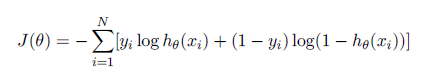

Write down the gradient update rule for the model parameter θ if it is trained with gradient descent.

(b) Consider a feed-forward neural network with one hidden layer and the sigmoid activation function.
We will use the same cross-entropy objective as in part (a). Write down the update rules for model
parameters during backpropagation.

# Problem 4 [Backpropagation implementation] 30 points

In this problem, you will implement your own backpropagation procedure for a neural network with one
hidden layer.

(a) Implement the backpropagation algorithm you derived in Problem 3, part (b), for a neural network with a single hidden layer, sigmoid activation, and cross-entropy objective.

(b) Train the network for 20 epochs using mini-batch SGD with batches of size 128 and plot a graph on how the accuracy and cross-entropy loss function (computed on the testing set) vary with the number of epochs. You can select and fix the number of neurons in the hidden layer and the learning rate.

(c) Vary the learning rate and report results for different learning rates (at least 3 different values). Discuss
how the metrics change as a function of learning rate and number of epochs.

In [15]:
# data for NN training 

NN_X_train = X_train_processed.transpose()
NN_y_train = y_train.values.reshape(-1,1).transpose()
NN_X_test = X_test_processed.transpose()
NN_y_test = y_test.values.reshape(-1,1).transpose()


n_x = NN_X_train.shape[0]
n_y = NN_y_train.shape[0]
n_h = 4
m = NN_y_train.shape[1]  

# #test
# n_x = 2
# n_y = 1
# n_h = 4
# m = 400

print ('The size of input is: ' + str(n_x))
print ('The size of hidden layer is: ' + str(n_h))
print ('The size of output is: ' + str(n_y))
print ('training examples!', m)

The size of input is: 54
The size of hidden layer is: 4
The size of output is: 1
training examples! 30162


In [16]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [17]:
def initialize_parameters(n_x, n_h, n_y):
  np.random.seed(2)

  W1 = np.random.randn(n_h, n_x)*0.01
  b1 = np.zeros(shape=(n_h, 1))
  W2 = np.random.randn(n_y, n_h)*0.01
  b2 = np.zeros(shape=(n_y, 1))

  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
  
  return parameters

In [18]:
def forward_propogation(X, parameters):
  # get the parameters from the parameters dictionary
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']

  # forward propogation
  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = sigmoid(Z2)

  assert(A2.shape == (1, X.shape[1]))
    
  cache = {"Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2}
  
  return A2, cache

In [91]:
# # test 
# X = np.random.randn(2,400)
# parameters = initialize_parameters(n_x, n_h, n_y)
# A2, cache = forward_propogation(X, parameters)

In [19]:
def compute_loss(A2, Y, parameters):
  m = Y.shape[1]

  # logistic regression loss function 

  logprobs = np.log(A2)*Y + (1 - Y)*np.log(1 - A2)
  cost = - np.sum(logprobs) / m

  return np.squeeze(cost)

In [93]:
# # test 
# Y = np.random.choice([0, 1], size=m, p=[.5, .5]).reshape(-1,1).transpose()
# compute_loss(A2, Y, parameters)

In [20]:
def backward_propogation(parameters, cache, X, Y):
  # get the parameters from the dictionary

  m = Y.shape[1]

  W1 = parameters['W1']
  W2 = parameters['W2']

  A1 = cache['A1']
  A2 = cache['A2']

  # back propogation 

  dZ2= A2 - Y
  dW2 = (1 / m) * np.dot(dZ2, A1.T)
  db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
  dZ1 = np.dot(W2.T, dZ2)* (1 - np.power(A1, 2))
  dW1 = (1 / m) * np.dot(dZ1, X.T)
  db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
  
  grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}
  
  return grads


In [73]:
# # test
# grads = backward_propogation(parameters, cache, X, Y)
# grads

In [43]:
def parameters_update(parameters, grads, learning_rate=2):
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']

  dW1 = grads['dW1']
  db1 = grads['db1']
  dW2 = grads['dW2']
  db2 = grads['db2']

  W1 = W1 - learning_rate * dW1
  b1 = b1 - learning_rate * db1
  W2 = W2 - learning_rate * dW2
  b2 = b2 - learning_rate * db2
      
  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
  
  return parameters

In [44]:
# with mini batch SGD 

parameters = initialize_parameters(n_x, n_h, n_y)
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']

def nn(parameters, X, Y):     
  A2, cache = forward_propogation(X, parameters)
  cost = compute_loss(A2, Y, parameters)  
  grads = backward_propogation(parameters, cache, X, Y)
  parameters = parameters_update(parameters, grads)
  return parameters, cost

In [85]:
#parameters = nn(NN_X_train, NN_y_train, num_iterations=1000)

In [25]:
def predict(parameters, X):
  A2, cache = forward_propogation(X, parameters)
  predictions = np.where(A2 >= 0.5, 1, 0)
  return predictions

In [26]:
n_iter = 20
import sklearn 

def mini_batch(parameters, X_train, y_train, minibatch_size):
    overall_loss = []
    overall_accuracy = []
    for iter in range(n_iter):        
        X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
        for i in range(0, X_train.shape[0], minibatch_size):
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]
            parameters, cost = nn(parameters, X_train_mini.transpose(), y_train_mini.transpose())
            overall_loss.append(cost)

            # get the accuracy 
            NN_y_pred = predict(parameters, NN_X_test)
            accuracy = accuracy_score(NN_y_pred.squeeze(), y_test)
            overall_accuracy.append(accuracy)

            if i% 100 == 0:
              print ("Cost after iteration %i: %f" % (iter, cost))
    return parameters, overall_loss, overall_accuracy

In [50]:
minibatch_size = 128
parameters, overall_loss, overall_accuracy = mini_batch(parameters, NN_X_train.transpose(), NN_y_train.transpose(), minibatch_size)

Cost after iteration 0: 0.374554
Cost after iteration 0: 0.335027
Cost after iteration 0: 0.279698
Cost after iteration 0: 0.408980
Cost after iteration 0: 0.296503
Cost after iteration 0: 0.347480
Cost after iteration 0: 0.447948
Cost after iteration 0: 0.334307
Cost after iteration 0: 0.441465
Cost after iteration 0: 0.294498
Cost after iteration 1: 0.315114
Cost after iteration 1: 0.385763
Cost after iteration 1: 0.340121
Cost after iteration 1: 0.450981
Cost after iteration 1: 0.446085
Cost after iteration 1: 0.423553
Cost after iteration 1: 0.368974
Cost after iteration 1: 0.415269
Cost after iteration 1: 0.411988
Cost after iteration 1: 0.363651
Cost after iteration 2: 0.298310
Cost after iteration 2: 0.282289
Cost after iteration 2: 0.371326
Cost after iteration 2: 0.396219
Cost after iteration 2: 0.354530
Cost after iteration 2: 0.350590
Cost after iteration 2: 0.324588
Cost after iteration 2: 0.290415
Cost after iteration 2: 0.373151
Cost after iteration 2: 0.357294
Cost after

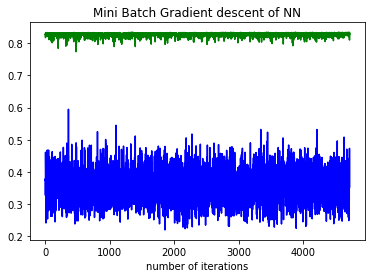

In [51]:
import matplotlib.pyplot as plt
plt.plot(overall_loss, color='blue')
plt.plot(overall_accuracy, color='green')
plt.xlabel('number of iterations')
plt.title('Mini Batch Gradient descent of NN')
plt.show()

In [47]:
NN_y_pred = predict(parameters, NN_X_test)

In [48]:
np.unique(NN_y_pred, return_counts=True)

(array([0, 1]), array([11373,  3687]))

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, NN_y_pred.squeeze()))

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     11360
         1.0       0.65      0.65      0.65      3700

    accuracy                           0.83     15060
   macro avg       0.77      0.77      0.77     15060
weighted avg       0.83      0.83      0.83     15060



# **References** 

https://stackoverflow.com/questions/25427650/sklearn-logisticregression-without-regularization

https://stackoverflow.com/questions/48185090/how-to-get-the-log-likelihood-for-a-logistic-regression-model-in-sklearn

https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74